<a href="https://colab.research.google.com/github/yuvalwas/MDAN-course/blob/main/MDAN_T3_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [373]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams['figure.dpi'] = 140
plt.rcParams['legend.frameon'] = False
from matplotlib.ticker import MultipleLocator
ml = MultipleLocator(1)

# Tutorial 3

# How do we use statistics concepts in analysizing neural data.

### Lets try to decode position from place cells

Sheintuch L., Rubin A., Brande-Eilat N., Geva N., Sadeh N., Pinchasof O. & Ziv Y. (2017). Tracking the Same Neurons across Multiple Days in Ca2+ Imaging Data.  Cell Reports. 2017 Oct , 21 (4):1102-1115.

In [374]:
from IPython.display import HTML

HTML("""
    <video alt="test"  width="640" height="480" controls>
        <source src="mouse_demo_video.mp4" type="video/mp4">
    </video>
""")

In [375]:
position = np.load('position.npy') - 1 # approximately 50 ms bins
position.shape

(18137,)

In [376]:
all_positions = np.sort(np.unique(position))
n_positions = len(all_positions)
print(np.unique(position))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [377]:
neuronal_activity = np.load('neuronal_activity.npy') # 0/1 matrix with ones are detected events
n_neurons, n_time_points = neuronal_activity.shape
n_neurons, n_time_points

(452, 18137)

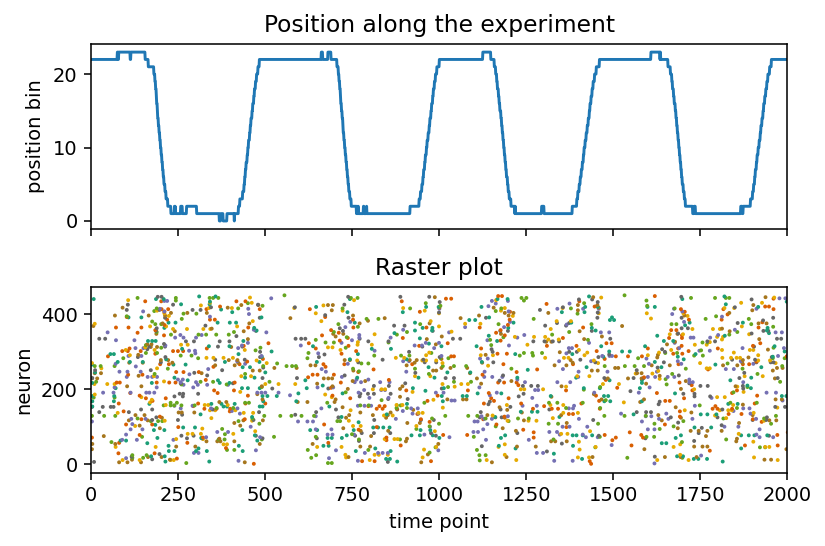

In [378]:
#hidden
#@title View (part of) data
fig,axs = plt.subplots(2,1,sharex=True)
axs[0].plot(position)
axs[0].set(ylabel='position bin', title='Position along the experiment')

neuron, event_time_points = np.where(neuronal_activity)
axs[1].scatter(event_time_points, neuron, s=1, c=neuron%7, cmap='Dark2')
axs[1].set(xlabel='time point', ylabel='neuron', title='Raster plot', xlim=(0,2000))

plt.tight_layout()

We want to predict the position of the animal given the neural data at some time point. Using Bayesian framework, we want to calculate the posterior probability 

\begin{align}
P\text{ (position | active neurons)} &∝ P \text{(active neurons | position)} \cdot P \text{(position)}  \\
\text{posterior} &∝ \text{likelihood} \cdot \text{prior}
\end{align}



# 1. likelihood
## 1.1 Compute likelihood of each neuron
First step - we compute $P \text{(neuron } i \text{ active | position)}$ for each of the neurons. Intuitively we compute it as the number of times a neuron was active at some position $(k)$, divided by number of time points it spent in that position $(n)$: $P \text{(neuron } i \text{ active | position)} = \frac{k}{n}$.

**A note about the model's assumptions:**<br>
Here we assume that each neuron has a (biased) coin for each position (with $p=\frac{k}{n}$). In each position, the neuron flips the appropriate coin, and becomes active if the coin gives heads. If the neuron is a place cell, for example, then inside a place field the probability of heads is high and outside the place field the probability is low. Importantly, the coins don't change throughout the experiment (activity depends only on position).

In [379]:
df = pd.DataFrame(neuronal_activity.T, columns=[f'neuron {i}' for i in range(n_neurons)]) # df just contains all data
df['position'] = position
df.index.name = 'time point'
df

,neuron 0,neuron 1,neuron 2,neuron 3,neuron 4,neuron 5,neuron 6,neuron 7,neuron 8,neuron 9,...,neuron 443,neuron 444,neuron 445,neuron 446,neuron 447,neuron 448,neuron 449,neuron 450,neuron 451,position
time point,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [380]:
time_spent = df.position.value_counts().sort_index()
time_spent

0       21
1     4975
2     1378
3      277
4      214
5      187
6      236
7      185
8      150
9      138
10     153
11     157
12     147
13     148
14     146
15     142
16     158
17     158
18     175
19     190
20     265
21     511
22    7404
23     622
Name: position, dtype: int64

In [381]:
time_active = df.groupby('position').sum().T
time_active

position,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
neuron 0,0,0,0,0,0,0,0,0,1,0,...,1,2,2,0,0,1,0,0,1,0
neuron 1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,3,1,0,0,0,4,1
neuron 2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,4
neuron 3,0,11,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,4
neuron 4,0,0,0,0,0,1,1,3,1,0,...,0,1,1,1,0,1,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
neuron 447,0,1,0,0,0,1,0,8,3,3,...,1,0,1,0,0,0,0,0,0,1
neuron 448,0,14,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
neuron 449,0,4,1,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,4,2
neuron 450,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [382]:
p_active = time_active / time_spent
p_active

position,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
neuron 0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.006667,0.000000,...,0.006849,0.014085,0.012658,0.000000,0.000000,0.005263,0.000000,0.000000,0.000135,0.000000
neuron 1,0.0,0.000402,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.018987,0.005714,0.000000,0.000000,0.000000,0.000540,0.001608
neuron 2,0.0,0.000201,0.000726,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001957,0.000405,0.006431
neuron 3,0.0,0.002211,0.000726,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001891,0.006431
neuron 4,0.0,0.000000,0.000000,0.00000,0.0,0.005348,0.004237,0.016216,0.006667,0.000000,...,0.000000,0.007042,0.006329,0.006329,0.000000,0.005263,0.003774,0.000000,0.000270,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
neuron 447,0.0,0.000201,0.000000,0.00000,0.0,0.005348,0.000000,0.043243,0.020000,0.021739,...,0.006849,0.000000,0.006329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001608
neuron 448,0.0,0.002814,0.000726,0.00000,0.0,0.000000,0.004237,0.000000,0.000000,0.000000,...,0.006849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000135,0.000000
neuron 449,0.0,0.000804,0.000726,0.00361,0.0,0.000000,0.000000,0.005405,0.000000,0.000000,...,0.006849,0.000000,0.000000,0.000000,0.005714,0.000000,0.000000,0.000000,0.000540,0.003215
neuron 450,0.0,0.000000,0.002177,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


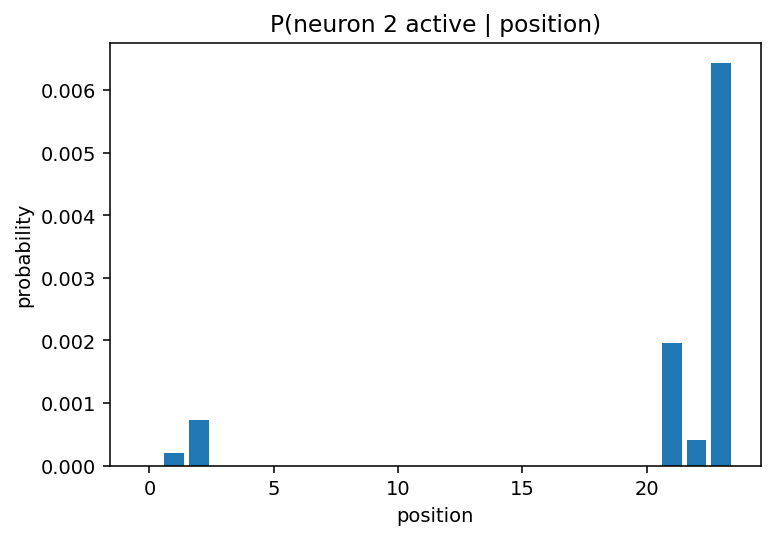

In [383]:
#@title View a single neuron
neuron_to_plot = 2 #@param
plt.bar(all_positions, p_active.iloc[neuron_to_plot, :])
plt.ylabel('probability')
plt.xlabel('position')
plt.title(f'P(neuron {neuron_to_plot} active | position)');

Now let's view all neurons. The figure above corresponds to a row in the figure below.

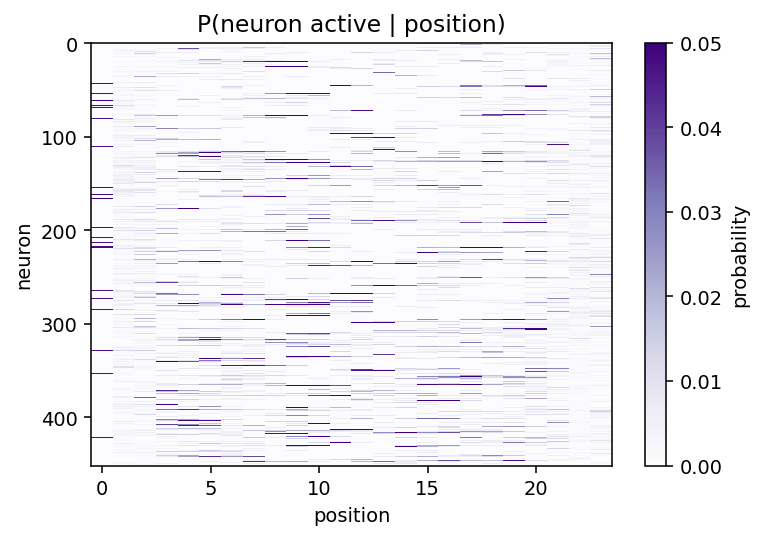

In [384]:
#hidden
#@title View all neurons
plt.imshow(p_active, aspect='auto', cmap='Purples', interpolation='nearest', vmax=0.05)
plt.colorbar(label='probability')
plt.xlabel('position')
plt.ylabel('neuron')
plt.title('P(neuron active | position)');

In [385]:
#@title Likelihood function for a single neuron
def likelihood_of_neuron(neuron, active:bool, pos):
  if active:
    return p_active.iloc[neuron, pos]
  else:
    return 1 - p_active.iloc[neuron, pos]

In [386]:
## examples
print(likelihood_of_neuron(neuron=2, active=0, pos=14))
print(likelihood_of_neuron(neuron=2, active=1, pos=14))
print(likelihood_of_neuron(neuron=4, active=0, pos=14))
print(likelihood_of_neuron(neuron=4, active=1, pos=14))

1.0
0.0
1.0
0.0


# 1.2 Likelihood of an activity pattern
Now we multiply the likelihood of each neuron to get the likelihood of an activity pattern:
\begin{gather}
P(\text{neuron 1 active, neuron 2 inactive, neuron 3 active, ... | position}) = \\
P(\text{neuron 1 active | position}) \cdot P(\text{neuron 2 inactive | position}) \cdot P(\text{neuron 3 active | position}) \cdots
\end{gather}


**A note about the model's assumptions:**<br>
We assume the neurons are independent. Per position, each neuron is flipping its own coin to decide whether to acivate, and the coins don't interact. This is generally not true, but the model is still useful.

In [387]:
def likelihood_of_pattern(pattern, pos):
  return np.prod([likelihood_of_neuron(neuron, active, pos) for neuron, active in enumerate(pattern)])

In [388]:
# example
time_point = 952 #@param
pattern = neuronal_activity[:, time_point]
pos = position[time_point]
print('pattern =', pattern)
print(f'pattern\'s likelihood to come from position {pos} =', likelihood_of_pattern(pattern, pos))

pattern = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
pattern's likelihood to come from position 5 = 2.5974340850078933e-06


Now let's say we don't know in which position this pattern was measured. We plot the pattern's likelihood for each position (the likelihood function).

In [389]:
likelihood = [likelihood_of_pattern(pattern, pos) for pos in all_positions]
MLE = np.argmax(likelihood) # maximum likelihood estimator

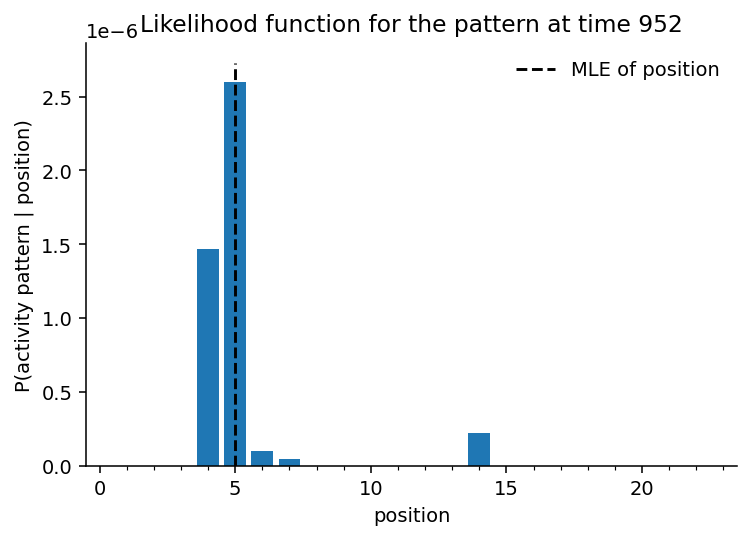

In [390]:
#hidden
#@title plot likelihood
plt.bar(all_positions, likelihood)
plt.ylabel('P(activity pattern | position)')
plt.xlabel('position')
plt.title(f'Likelihood function for the pattern at time {time_point}')
plt.vlines(MLE, *plt.ylim(), 'black', 'dashed', label='MLE of position')
plt.legend()
sns.despine()
plt.xlim(-0.5, all_positions[-1]+0.5)
plt.gca().xaxis.set_minor_locator(ml)

At this point, if we had to predict one location for this pattern, we would choose the position the maximizes the likelihood.

# 2. Prior
So far, we didn't take into account the fact the the animal is more likely to be in some positions than others (it spent much more time in the edges than in any middle point). 

Notice that the prior does not depend on the time / position we are currently predicitng location for.


In [391]:
prior = time_spent / time_spent.sum()

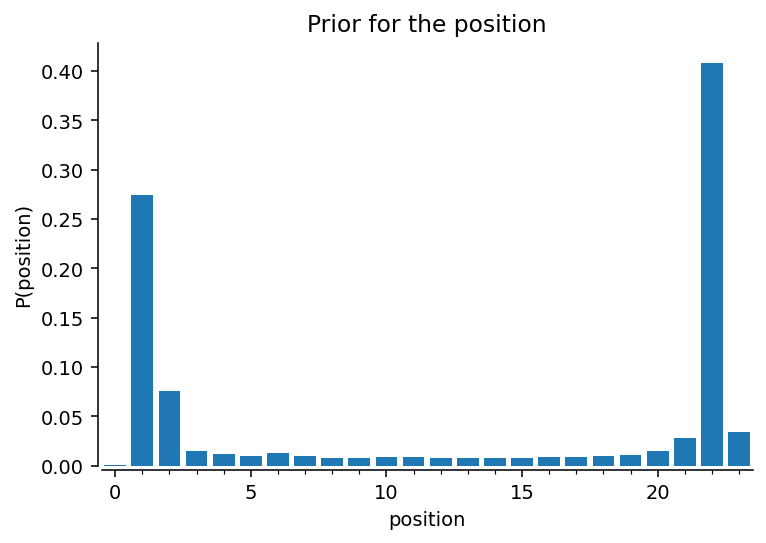

In [392]:
#hidden
#@title plot prior
plt.bar(all_positions, prior)
plt.ylabel('P(position)')
plt.xlabel('position')
plt.title('Prior for the position')
sns.despine(offset=2)
plt.xlim(-0.5, all_positions[-1]+0.5)
plt.gca().xaxis.set_minor_locator(ml)

# 3. Posterior
Now we put it together by multiplying the prior with the likelihood (and normalizing), to get the posterior for our example pattern.

In [393]:
posterior = prior * likelihood
posterior /= posterior.sum()
MAP = posterior.argmax() # maximum a-posteriori

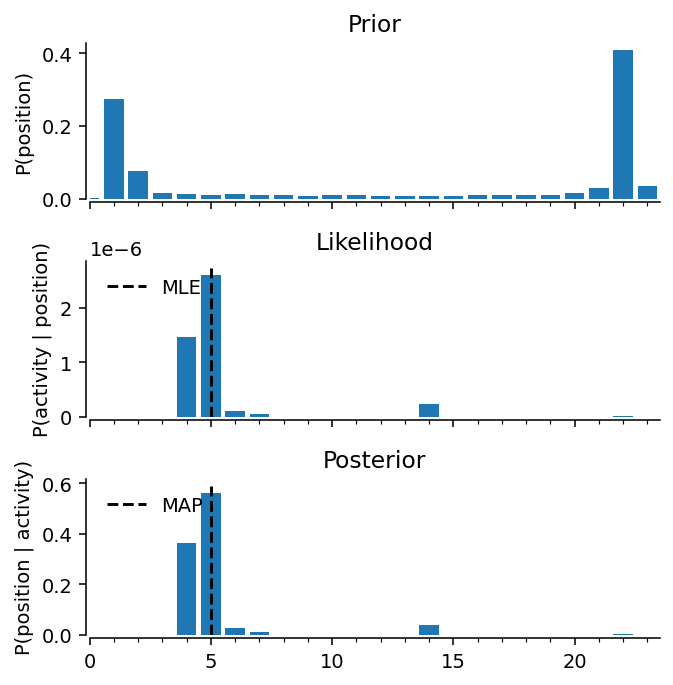

In [394]:
fig, axs = plt.subplots(3, 1, figsize=(5,5), sharex=True)

axs[0].bar(all_positions, prior)
axs[0].set(ylabel='P(position)', title='Prior');

axs[1].bar(all_positions, likelihood)
axs[1].set(ylabel='P(activity | position)', title=f'Likelihood');
axs[1].vlines(MLE, *axs[1].get_ylim(), 'black', 'dashed', label='MLE')
axs[1].legend(loc='upper left')

axs[2].bar(all_positions, posterior)
axs[2].set(ylabel='P(position | activity)', title=f'Posterior');
axs[2].vlines(MAP, *axs[2].get_ylim(), 'black', 'dashed', label='MAP')
axs[2].legend(loc='upper left')

sns.despine(offset=2)
axs[2].xaxis.set_minor_locator(ml)
axs[2].set_xlim(0, all_positions[-1]+0.5)
plt.tight_layout()

Notice that as we said previously, the posterior is a compromise between the prior and the likelihood. Mathematically, this compromise is their product. This means that if one of the components in the compromise is zero, the result will always be zero. In this case we have zero in the likelihood for some of the positions. Recall that in the previous tutorial, we discussed the case of zeros in the prior.

As we said before, assigning zero probability to some event is a very strong statement - it means we are absolutely confident that that event is **impossible**. However, our likelihood was estimated by very finite data. 
Recall how we calculated the likelihood:
$$\text{likelihood} =  P(\text{activity of neuron 1 | position}) \cdot P(\text{activity of  neuron 2 | position}) \cdots = \frac{k_1}{n}\cdot\frac{k_2}{n}\cdots$$
i.e., it is enough that a single neuron was never active in some position during the recording for the likelihood of the pattern at that position to be zero.

One way to fix this is smoothing the likelihood. We'll use Additive Smoothing.

## Additive smoothing

PReviously we calculated $p=\frac{k}{n}$. Using additive smoothing we calculate instead
$$ p_{AS}= \frac{k+1}{n+2}$$
This prevents $p$ from being 0 or 1 while changing only slightly probabilities in between.


In [395]:
p_active = (time_active+1) / (time_spent+2)

def likelihood_of_neuron(neuron, active:bool, pos):
  if active:
    return p_active.iloc[neuron, pos]
  else:
    return 1 - p_active.iloc[neuron, pos]

likelihood = [likelihood_of_pattern(pattern, pos) for pos in all_positions]
MLE = np.argmax(likelihood) # maximum likelihood estimator

posterior = prior * likelihood
posterior /= posterior.sum()
MAP = posterior.argmax() # maximum a-posteriori

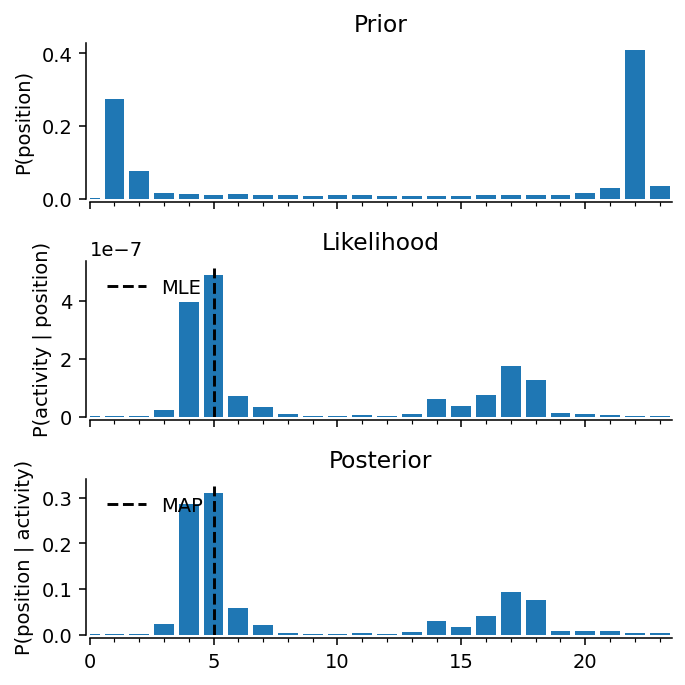

In [396]:
fig, axs = plt.subplots(3, 1, figsize=(5,5), sharex=True)

axs[0].bar(all_positions, prior)
axs[0].set(ylabel='P(position)', title='Prior');

axs[1].bar(all_positions, likelihood)
axs[1].set(ylabel='P(activity | position)', title=f'Likelihood');
axs[1].vlines(MLE, *axs[1].get_ylim(), 'black', 'dashed', label='MLE')
axs[1].legend(loc='upper left')

axs[2].bar(all_positions, posterior)
axs[2].set(ylabel='P(position | activity)', title=f'Posterior');
axs[2].vlines(MAP, *axs[2].get_ylim(), 'black', 'dashed', label='MAP')
axs[2].legend(loc='upper left')

sns.despine(offset=2)
axs[2].xaxis.set_minor_locator(ml)
axs[2].set_xlim(0, all_positions[-1]+0.5)

plt.tight_layout()

In [397]:
# Note: calculating this is very slow, but it is the most direct way
# MAPs = []
# for pattern in neuronal_activity.T:
#   likelihood = [likelihood_of_pattern(pattern, pos) for pos in all_positions]
#   MAP = (prior * likelihood).argmax()
#   MAPs.append(MAP)

In [398]:
# A much more efficient way to calculate 
log_p_active = np.log(p_active.to_numpy())
log_p_inactive = np.log(1-p_active.to_numpy())
tiled_patterns = np.tile(neuronal_activity, (24,1,1)).transpose(2,1,0)
loglikelihood = (tiled_patterns*log_p_active + (1-tiled_patterns)*log_p_inactive).sum(axis=1)
log_prior = np.log(prior.to_numpy())
MAPs = p_active.columns[(loglikelihood + log_prior).argmax(axis=1)].to_numpy()
MAPs

array([22, 22, 22, ..., 22, 22, 22], dtype=uint64)

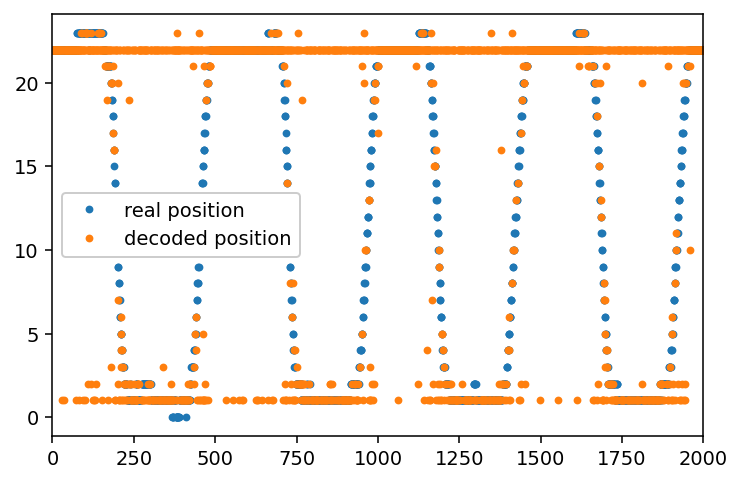

In [399]:
plt.plot(position, '.', label='real position')
plt.plot(MAPs, '.', label='decoded position')
plt.xlim(0, 2000)
plt.legend(frameon=True, framealpha=1);

In [400]:
np.corrcoef(position, MAPs)[0,1] # pearson correlation between real and decoded position

0.45834450173961433

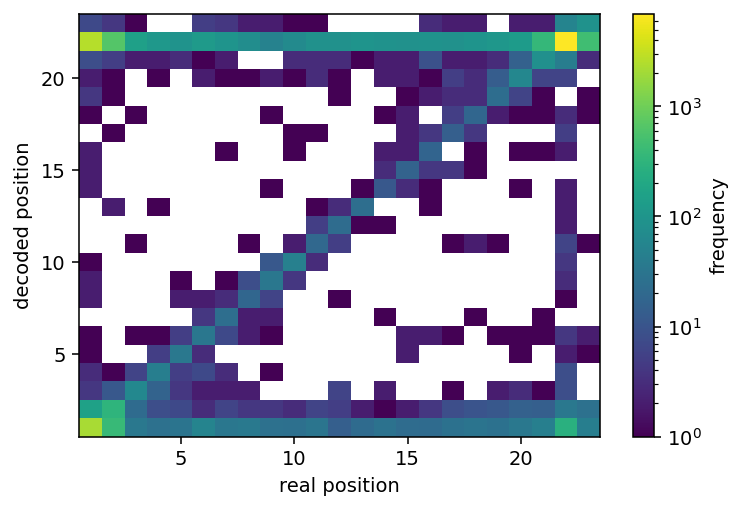

In [401]:
plt.hist2d(position, MAPs,
            norm = colors.LogNorm(),
            bins = np.arange(0.5,24.5,1))
plt.colorbar(label='frequency')
plt.xlabel('real position')
plt.ylabel('decoded position');